In [1]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_bs = 16
test_bs = 16
lr_init = 0.0001
max_epoch = 5

In [2]:
import glob
import os

train_path = '../data/cat_dog/training_set/training_set/'
test_path = '../data/cat_dog/test_set/test_set/'

train_all = {}
test_all = {}

for trainable in [True, False]:
    if trainable:
        for category in ['cats', 'dogs']:
            train_all[category] = glob.glob(os.path.join(train_path + category, '*.jpg'))
    else:
        for category in ['cats', 'dogs']:
            test_all[category] = glob.glob(os.path.join(test_path + category, '*.jpg'))

In [3]:
print(
    'train cats: ',len(train_all['cats']),'\n',
    'train dogs:', len(train_all['dogs']),'\n',
    'test cats: ',len(test_all['cats']),'\n',
    'test dogs: ',len(test_all['dogs']),'\n',
    )

train cats:  3999 
 train dogs: 4004 
 test cats:  1011 
 test dogs:  1012 



In [4]:
x, y = [], []
Outlier = []
for category in ['cats', 'dogs']:
    for path in train_all[category]:
        img = Image.open(path)
        x.append(img.size[0])
        y.append(img.size[1])
        if img.size[0] >= 600:
            Outlier.append(path)
print(Outlier)

[]


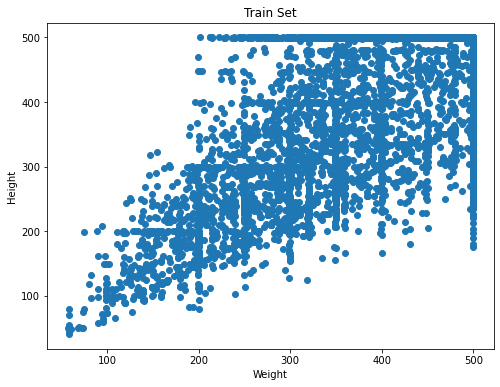

In [5]:
plt.figure(figsize = (8,6))
plt.scatter(x, y)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Train Set')
plt.show()

In [6]:
# 测试集散点图分布
x, y = [], []
for category in ['cats', 'dogs']:
    for path in test_all[category]:
        img = Image.open(path)
        x.append(img.size[0])
        y.append(img.size[1])

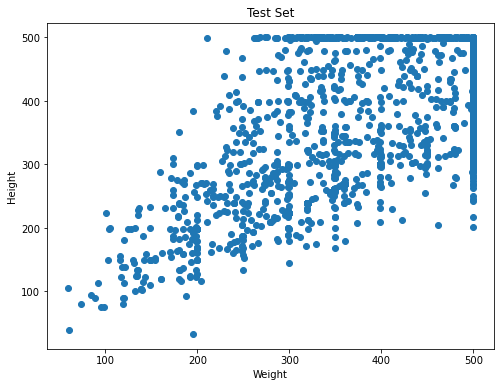

In [7]:
plt.figure(figsize = (8,6))
plt.scatter(x, y)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Test Set')
plt.show()

In [8]:
mapkey = {
    'cats':'0',
    'dogs':'1',
}

    
def gen_txt(txt_path, img_paths):
    
    f = open(txt_path, 'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label + '\n'
            f.write(line)

gen_txt('../data/cat_dog/train.txt', train_all)
gen_txt('../data/cat_dog/test.txt', test_all)

In [9]:
# 计算训练集的均值和标准差


train_paths = train_all['cats'] + train_all['dogs']

m_list, s_list = [], []
for path in tqdm(train_paths):
    img = cv2.imread(path)
    img = img / 255.0
    m, s = cv2.meanStdDev(img)
    m_list.append(m.reshape((3,)))
    s_list.append(s.reshape((3,)))
m_array = np.array(m_list)
s_array = np.array(s_list)
m = m_array.mean(axis=0, keepdims=True)
s = s_array.mean(axis=0, keepdims=True)
# BGR -> RGB
print(m[0][::-1])
print(s[0][::-1])

100%|█████████████████████████████████████████████████████████████████████████████| 8003/8003 [00:30<00:00, 264.03it/s]

[0.48827705 0.45510637 0.41741   ]
[0.22971935 0.22475049 0.22525084]


In [10]:
class MyDataset(Dataset):
    def __init__(self, txt_path, transform=None, target_transform=None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))

        self.imgs = imgs        # 最主要就是要生成这个list， 然后DataLoader中给index，通过getitem读取图片数据
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')     # 像素值 0~255，在transfrom.totensor会除以255，使像素值变成 0~1

        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等

        return img, label

    def __len__(self):
        return len(self.imgs)

In [11]:
normMean = [0.48827705, 0.45510637, 0.41741   ]
normStd = [0.22971935, 0.22475049, 0.22525084]
normTransform = transforms.Normalize(normMean, normStd)
trainTransform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((280,280)),
#     transforms.RandomCrop((224,224), padding=28),
#     transforms.RandomRotation(degrees = 30),
    transforms.ToTensor(),
    normTransform,
])

testTransform = transforms.Compose([
    transforms.Resize((280,280)),
    transforms.ToTensor(),
    normTransform,
])

In [12]:
train_txt_path = '../data/cat_dog/train.txt'
test_txt_path = '../data/cat_dog/test.txt'

train_data = MyDataset(txt_path=train_txt_path, transform=trainTransform)
test_data = MyDataset(txt_path=test_txt_path, transform=testTransform)

In [13]:
for image,label in test_data:
    print(image.shape)
    break

torch.Size([3, 280, 280])


In [14]:
train_loader = DataLoader(dataset=train_data, batch_size=train_bs, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_bs)

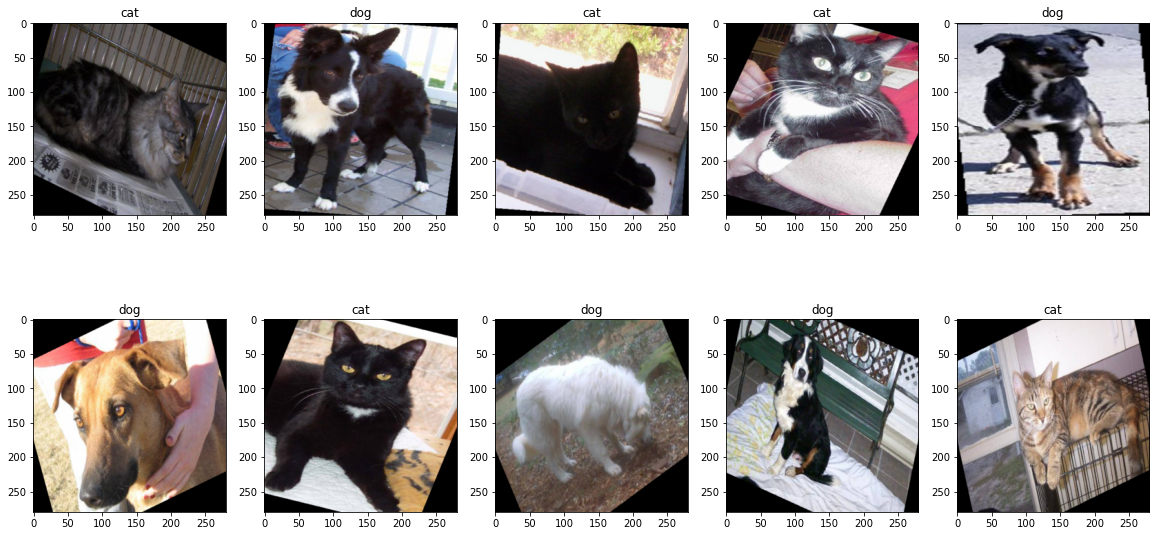

In [15]:
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    normStd = [0.22971935, 0.22475049, 0.22525084]
    normMean = [0.48827705, 0.45510637, 0.41741   ]
    img = img*normStd + normMean
    return img


def plot_10():
        iter_ = iter(train_loader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}
        
        plt.figure(figsize=(20,10))
        for idx in range(10):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()

plot_10()

In [16]:
class fc_part(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512,120)
        self.fc2 = nn.Linear(120, 2)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
model = resnet18(pretrained=True).to(device)
model.fc = fc_part().to(device)

In [21]:
# images, labels = next(iter(train_loader))
# if torch.cuda.is_available():
#     images = images.to(device)
# grid = torchvision.utils.make_grid(images)
# comment = f'batch_size{train_bs} lr{lr_init}'
# tb = SummaryWriter(comment=comment)
# tb.add_image('images', grid)
# tb.add_graph(model, images)

In [22]:
## 按需设置学习率, 因为我们全连接层前面的权重全是预训练加载来的权重, 因此Finetune一下就行

ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())

In [23]:
optimizer = optim.SGD([
    {'params': base_params},
    {'params': model.fc.parameters(), 'lr': lr_init*10}],  lr_init, momentum=0.9, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()                                                   # 选择损失函数
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)     # 设置学习率下降策略

In [24]:
for epoch in range(1, max_epoch+1):

    train_loss = 0.0    # 记录一个epoch的loss之和
    train_correct = 0.0
    train_total = 0.0
    
    scheduler.step()  # 更新学习率
    
    with tqdm(train_loader, desc = 'Train') as t:
        model.train()
        for data in t:
            # 获取图片和标签
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward, backward, update weights
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 统计预测信息
            _, predicted = torch.max(outputs, axis = 1)
            train_total += labels.size(0)
            train_correct += torch.sum(predicted == labels).item()
            train_loss += loss.item()

            #设置进度条右边显示的信息
            t.set_postfix(train_loss = loss.item(), train_accuracy = train_correct / train_total)
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        model.eval()
        with tqdm(test_loader, desc = 'Test') as t:
            for data in t:                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                outputs = model.forward(inputs)
                loss = F.cross_entropy(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, axis = 1)
                test_total += labels.size(0)
                test_correct += torch.sum(predicted == labels).item()
                t.set_postfix(test_loss = loss.item(), test_accuracy = test_correct / test_total)
            
#     tb.add_scalar('train_loss', train_loss/train_total, epoch)
#     tb.add_scalar('train_accuracy', train_correct/train_total, epoch)
#     tb.add_scalar('test_loss', test_loss/test_total, epoch)
#     tb.add_scalar('test_accuracy', test_correct / test_total, epoch)

Train:  85%|██████████████████████████▍    | 428/501 [03:33<00:36,  2.00it/s, train_accuracy=0.973, train_loss=0.00426]


KeyboardInterrupt: 

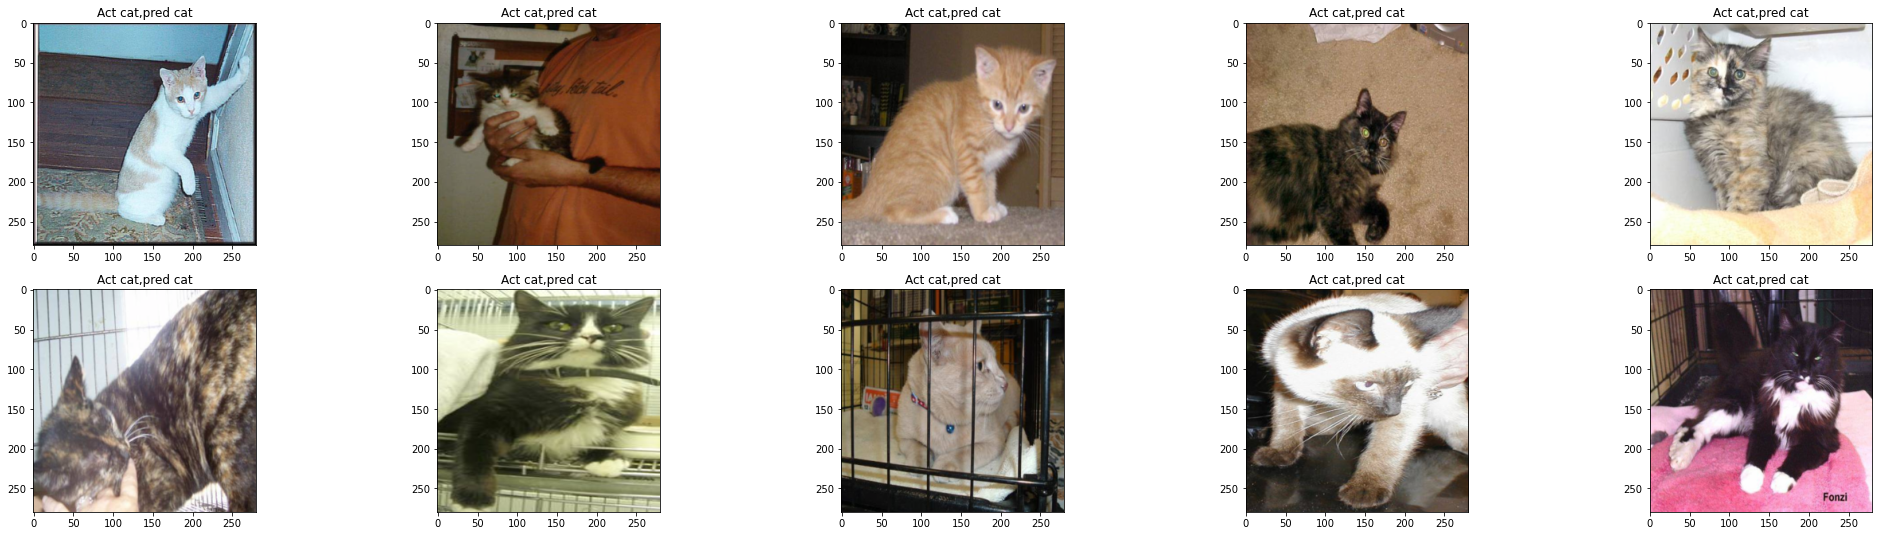

In [26]:
def plot_val_images():

    label_dict = ['cat','dog']
 
    iter_ = iter(test_loader)
    images,labels = next(iter_)
    images = images.to(device)
    pred_labels = labels.to(device)

    
    img_out = model.forward(images)
    value, index_val = torch.max(img_out, 1)

    # label = label_dict[str(label)]
    fig = plt.figure(figsize=(35,9))
    for idx in np.arange(10):
        ax = fig.add_subplot(2,5,idx+1)
        plt.imshow(image_convert(images[idx]))
        label = labels[idx]  
        pred_label = pred_labels[idx]
        ax.set_title('Act {},pred {}'.format(label_dict[label],label_dict[pred_label]))
        
plot_val_images()